In [1011]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, concatenate, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dropout
from keras.regularizers import l2
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.models import Model
from keras.layers.core import Reshape
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error


# Load data

ratings_df = pd.read_csv("data/ml-latest-small/ratings.csv")
movies_df = pd.read_csv("data/ml-latest-small/movies.csv")

pd.set_option('display.max_columns', 10) # this will show 10 collumns

# Check if GPU is visible to TensorFlow
gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print("GPU is visible to TensorFlow.")
else:
    print("GPU is not visible to TensorFlow.")

# Check if TensorFlow is using the GPU
if tf.test.is_gpu_available():
    print("TensorFlow is using GPU for computations.")
else:
    print("TensorFlow is using CPU for computations.")


GPU is not visible to TensorFlow.
TensorFlow is using CPU for computations.


In [1012]:
# Determine the maximum movie ID and user ID
max_movie_id = ratings_df['movieId'].max()
max_user_id = ratings_df['userId'].max()

# Print the maximum movie and user IDs
print(f'Max movie ID: {max_movie_id}')
print(f'Max user ID: {max_user_id}')


Max movie ID: 193609
Max user ID: 610


In [1013]:
print(movies_df.head())
movies_df.columns


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


Index(['movieId', 'title', 'genres'], dtype='object')

In [1014]:
print(ratings_df.head())
ratings_df.columns



   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [1015]:

movies_df.shape



(9742, 3)

In [1016]:

# Drop rows with missing titles
ratings_df.dropna(axis=0, inplace=True)
movies_df.dropna(axis=0, inplace=True)

# Normalize the rating values
mean_rating = ratings_df['rating'].mean()
std_rating = ratings_df['rating'].std()

# Check for null values
print(movies_df.isnull().sum())
print(ratings_df.isnull().sum())

print(movies_df.shape)
print(ratings_df.shape)


movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
(9742, 3)
(100836, 4)


In [1017]:


# Print the first few rows of the training dataset
print("Training dataset:")
print(train_df.head())

# Print the shape of the training dataset
print("Shape of the training dataset:", train_df.shape)

# Print the first few rows of the validation dataset
print("Validation dataset:")
print(val_df.head())

# Print the shape of the validation dataset
print("Shape of the validation dataset:", val_df.shape)

# Print the first few rows of the testing dataset
print("Testing dataset:")
print(test_df.head())

# Print the shape of the testing dataset
print("Shape of the testing dataset:", test_df.shape)


Training dataset:
       userId  movieId  rating   timestamp
67037     432    77866     4.5  1335139641
42175     288      474     3.0   978465565
93850     599     4351     3.0  1498524542
6187       42     2987     4.0   996262677
12229      75     1610     4.0  1158989841
Shape of the training dataset: (80669, 4)
Validation dataset:
       userId  movieId  rating   timestamp
49711     318    94677     4.0  1417280088
49833     318   148424     4.5  1457646243
16035     104     2325     3.5  1165481857
88697     573      356     4.5  1186589781
50468     325     5881     4.0  1039396851
Shape of the validation dataset: (10084, 4)
Testing dataset:
    userId  movieId  rating  timestamp
5        1       70     3.0  964982400
15       1      260     5.0  964981680
20       1      356     4.0  964980962
37       1      648     3.0  964982563
42       1      780     3.0  964984086
Shape of the testing dataset: (10083, 4)


In [1018]:


def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def clipped_rating(y_true, y_pred):
    return K.clip(y_pred, 1.0, 5.0)

def rating_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


In [1019]:
# Define custom metrics
metrics = [rmse, 'mae', rating_accuracy]


In [1050]:

# Split the data into training, validation, and testing sets
train_df = ratings_df.sample(frac=0.8, random_state=42)
val_test_ratings_df = ratings_df.drop(train_df.index)
val_df = val_test_ratings_df.sample(frac=0.5, random_state=42)
test_df = val_test_ratings_df.drop(val_df.index)

#define input layers
num_users = len(ratings_df.userId.unique())
num_movies = len(ratings_df.movieId.unique())
embedding_size = 128
movie_input = Input(shape=(1,))
user_input = Input(shape=(1,))

movie_embedding = Embedding(input_dim=193610, output_dim=32, name='movie_embedding')(movie_input)
user_embedding = Embedding(input_dim=611, output_dim=32, name='user_embedding')(user_input)

# Flatten the embedding layers
movie_vec = Flatten()(movie_embedding)
user_vec = Flatten()(user_embedding)

# Concatenate the flattened embedding layers
concat_vec = Concatenate()([movie_vec, user_vec])

# Add a dense layer with 256 units and ReLU activation
dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(concat_vec)
dropout1 = Dropout(0.5)(dense1)

# Add seconde dense layer with 64 units and ReLU activation
dense2 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout1)
dropout2 = Dropout(0.5)(dense2)

# Add third dense layer with 64 units and ReLU activation
#dense3 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout2)
#dropout3 = Dropout(0.5)(dense3)



# Add an output layer with a single unit and linear activation
output = Dense(1, activation='linear')(dropout2)


# Create the model with the input and output layers
model = Model(inputs=[movie_input, user_input], outputs=output)

# Define custom metrics
metrics = [rmse, 'mae', rating_accuracy]

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

# Compile the model with the Adam optimizer and mean squared error loss
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='mse', metrics=metrics)


In [1021]:
model.summary()
            

Model: "model_121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_244 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_245 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 32)        6195520     ['input_244[0][0]']              
                                                                                                  
 user_embedding (Embedding)     (None, 1, 32)        19552       ['input_245[0][0]']              
                                                                                          

In [1022]:
max_movieId = train_df['movieId'].max()
max_userId = train_df['userId'].max()

print(max_movieId)
print(max_userId)

193609
610


In [1023]:
history = model.fit(x=[train_df['movieId'], train_df['userId']], 
                    y=train_df['rating'],
                    batch_size=512, epochs=150, verbose=1,
                    validation_data=([val_df['movieId'], val_df['userId']], val_df['rating']),
                    callbacks=[early_stopping])

Epoch 1/150
158/158 [==============================] - 11s 62ms/step - loss: 3.0215 - rmse: 1.4685 - mae: 1.2502 - rating_accuracy: 0.2815 - val_loss: 1.0154 - val_rmse: 0.9048 - val_mae: 0.7062 - val_rating_accuracy: 0.4150
Epoch 2/150
158/158 [==============================] - 9s 59ms/step - loss: 1.1674 - rmse: 1.0019 - mae: 0.7905 - rating_accuracy: 0.3772 - val_loss: 0.9585 - val_rmse: 0.9086 - val_mae: 0.7176 - val_rating_accuracy: 0.3944
Epoch 3/150
158/158 [==============================] - 10s 61ms/step - loss: 1.0606 - rmse: 0.9732 - mae: 0.7665 - rating_accuracy: 0.3892 - val_loss: 0.8858 - val_rmse: 0.8890 - val_mae: 0.6913 - val_rating_accuracy: 0.4243
Epoch 4/150
158/158 [==============================] - 10s 60ms/step - loss: 0.9928 - rmse: 0.9539 - mae: 0.7507 - rating_accuracy: 0.3979 - val_loss: 0.8694 - val_rmse: 0.8937 - val_mae: 0.6956 - val_rating_accuracy: 0.4238
Epoch 5/150
158/158 [==============================] - 10s 60ms/step - loss: 0.9518 - rmse: 0.9433 - 

In [1024]:
# Evaluate the model on the test set
test_metrics = model.evaluate([test_df['movieId'], test_df['userId']], test_df['rating'])

print('Number of metrics:', len(test_metrics))
print('Test metrics:', test_metrics)

test_loss = test_metrics[0]
test_rmse = test_metrics[1]
test_mae = test_metrics[2]
test_rating_acc = test_metrics[3]


print('Test loss:', test_loss)
print('Test MAE:', test_mae)
print('Test RMSE:', test_rmse)
print('Test rating accuracy:', test_rating_acc)

316/316 [==============================] - 1s 2ms/step - loss: 0.7756 - rmse: 0.8534 - mae: 0.6702 - rating_accuracy: 0.4580
Number of metrics: 4
Test metrics: [0.7756011486053467, 0.8534005284309387, 0.6702085733413696, 0.4580366313457489]
Test loss: 0.7756011486053467
Test MAE: 0.6702085733413696
Test RMSE: 0.8534005284309387
Test rating accuracy: 0.4580366313457489


In [1025]:
# Evaluate the model on the train set

train_loss, train_mae, train_rmse, train_rating_acc = model.evaluate([train_df['movieId'], train_df['userId']], train_df['rating'])

print('Train loss:', train_loss)
print('Train MAE:', train_mae)
print('Train RMSE:', train_rmse)
print('Train rating accuracy:', train_rating_acc)

2521/2521 [==============================] - 5s 2ms/step - loss: 0.6109 - rmse: 0.7661 - mae: 0.5883 - rating_accuracy: 0.5090
Train loss: 0.6109094619750977
Train MAE: 0.7661305665969849
Train RMSE: 0.5882810950279236
Train rating accuracy: 0.5089762806892395


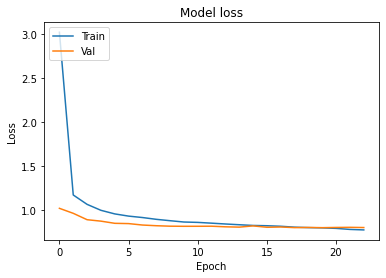

In [1026]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

316/316 [==============================] - 1s 2ms/step


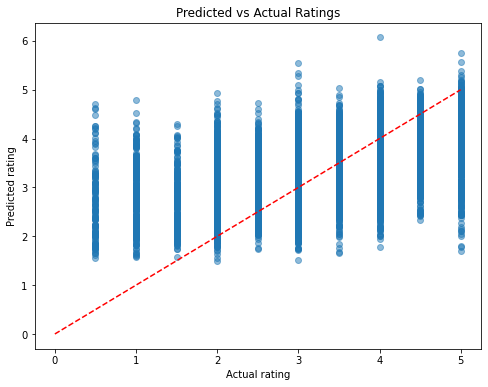

In [1027]:
# Plot the RMSE and MAE
plt.figure(figsize=(8, 6))
plt.scatter(test_df['rating'], model.predict([test_df['movieId'], test_df['userId']]), alpha=0.5)
plt.plot(np.arange(0, 5.5, 0.5), np.arange(0, 5.5, 0.5), 'r--')
plt.xlabel('Actual rating')
plt.ylabel('Predicted rating')
plt.title('Predicted vs Actual Ratings')
plt.show()


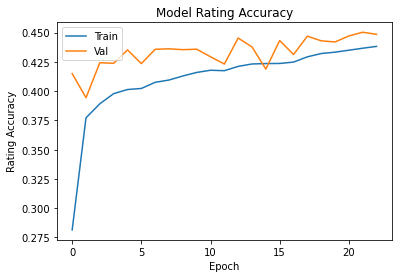

In [1028]:
# Plot training & validation rating accuracy values
plt.plot(history.history['rating_accuracy'])
plt.plot(history.history['val_rating_accuracy'])
plt.title('Model Rating Accuracy')
plt.ylabel('Rating Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [1045]:
# Get user and movie IDs from the user
user_id = 29
movie_id = 104841


# Use the model to predict the user's rating for the movie
predicted_rating = model.predict([np.array([movie_id]), np.array([user_id])])[0][0]

# Filter the ratings dataframe based on the user_id and movie_id
actual_rating = ratings_df[(ratings_df['userId'] == user_id) & (ratings_df['movieId'] == movie_id)]['rating'].values[0]

# Print the actual rating
print(f"Actual rating for movie {movie_id} by user {user_id}: {actual_rating:.2f}")
# Print the predicted rating
print(f"Predicted rating for movie {movie_id} by user {user_id}: {predicted_rating:.2f}")

1/1 [==============================] - 0s 24ms/step
Actual rating for movie 104841 by user 29: 4.00
Predicted rating for movie 104841 by user 29: 4.05


In [1049]:
# Loop through a list of user IDs and recommend movies for each user
for user_id in range(80, 83):
    # Create a list of all movies not yet rated by the user
    movies_not_watched = movies_df[~movies_df['movieId'].isin(ratings_df[ratings_df['userId']==user_id]['movieId'])]['movieId'].unique()

    # Create a dataframe with all combinations of user ID and movie ID
    user_movie_df = pd.DataFrame({'userId': user_id, 'movieId': movies_not_watched})

    # Predict the ratings for all user-movie combinations using the trained model
    user_movie_df['predicted_rating'] = model.predict([user_movie_df['movieId'], user_movie_df['userId']])

    # Clip the predicted ratings to a range of 0 to 5
    user_movie_df['predicted_rating'] = np.clip(user_movie_df['predicted_rating'], 0, 5)

    # Merge the user-movie dataframe with the movies dataframe to get the titles of the recommended movies
    recommended_movies = pd.merge(user_movie_df, movies_df[['movieId', 'title']], on='movieId')

    # Sort the predicted ratings in descending order and return the top 10 movies
    recommended_movies = recommended_movies.sort_values(by='predicted_rating', ascending=False).head(10)

    # Print the recommended movies with titles
    print(f"Recommended movies for user {user_id}:")
    print(recommended_movies[['title', 'predicted_rating']])
    print("\n")

300/300 [==============================] - 1s 2ms/step
Recommended movies for user 80:
                                                  title  predicted_rating
6799                                      Hunger (2008)               5.0
3704                                    Promises (2001)               5.0
7582                         What's Your Number? (2011)               5.0
5527                                     Nirvana (1997)               5.0
5544  Neon Genesis Evangelion: The End of Evangelion...               5.0
4576  Revolution Will Not Be Televised, The (a.k.a. ...               5.0
4579  Gloomy Sunday (Ein Lied von Liebe und Tod) (1999)               5.0
3245                               Game of Death (1978)               5.0
4582               My Architect: A Son's Journey (2003)               5.0
7550     Separation, A (Jodaeiye Nader az Simin) (2011)               5.0


304/304 [==============================] - 1s 2ms/step
Recommended movies for user 81:
          